In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 3a
commitnumber = 5014a19
conc = 0.0004
dv = 0.01
klin = 6.375563e-24
molecule = co2
ng_adju = [0, 0, 0]
ng_refs = [3, 2, 4]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250), (500, 250)]
tsfc = 257
vmax = 620
vmin = 540
w_diffuse = [(1.6, 1.6, 1.7), (1.75, 1.75), (1.55, 1.55, 1.6, 1.85)]
wgt = [(0.7, 0.3, 0.7), (0.7, 0.6), (0.4, 0.5, 0.8, 0.95)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

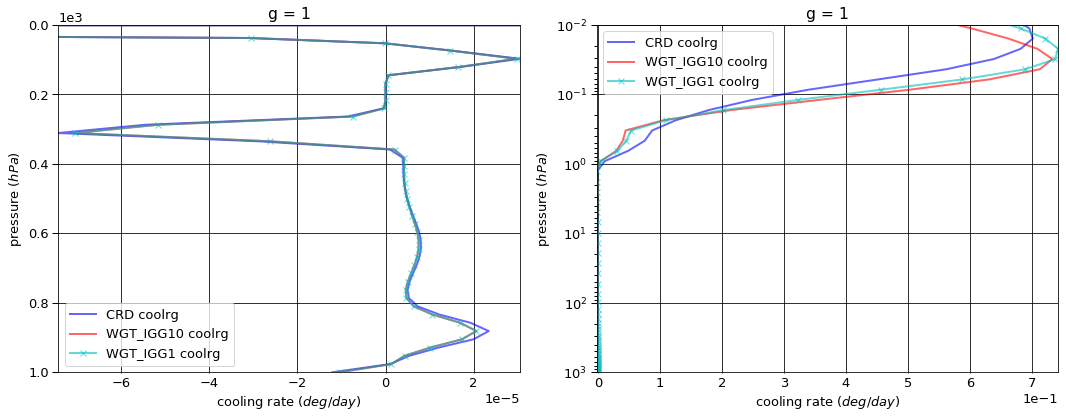

# Figure: cooling rate g-group 2

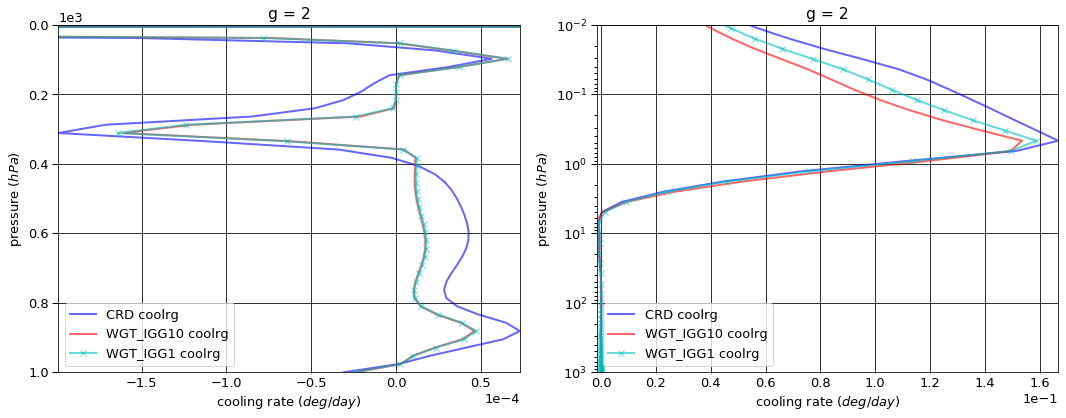

# Figure: cooling rate g-group 3

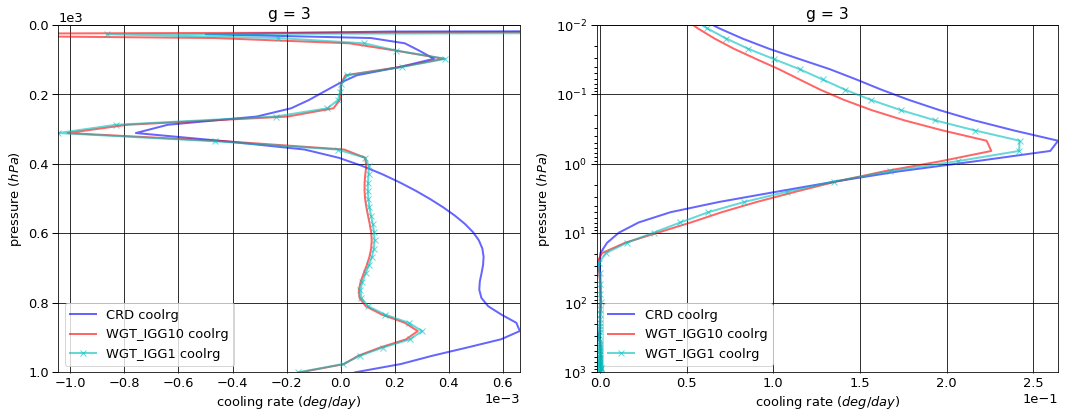

# Figure: cooling rate g-group 4

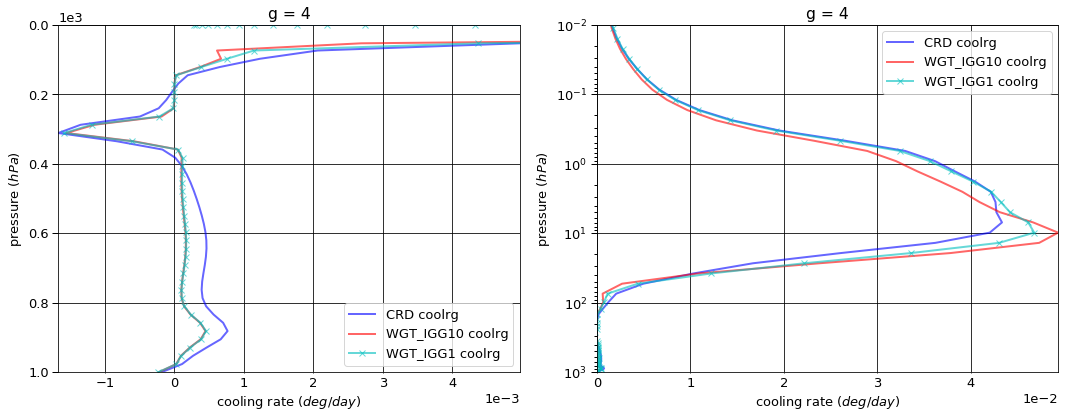

# Figure: cooling rate g-group 5

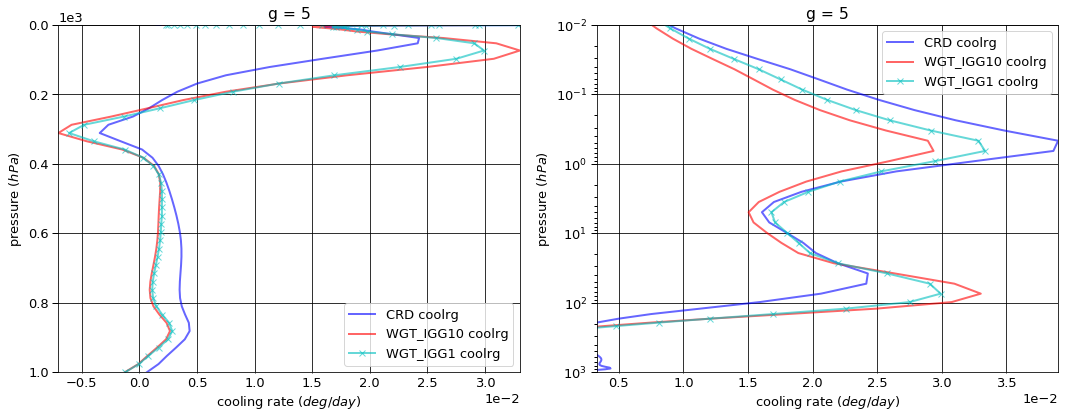

# Figure: cooling rate g-group 6

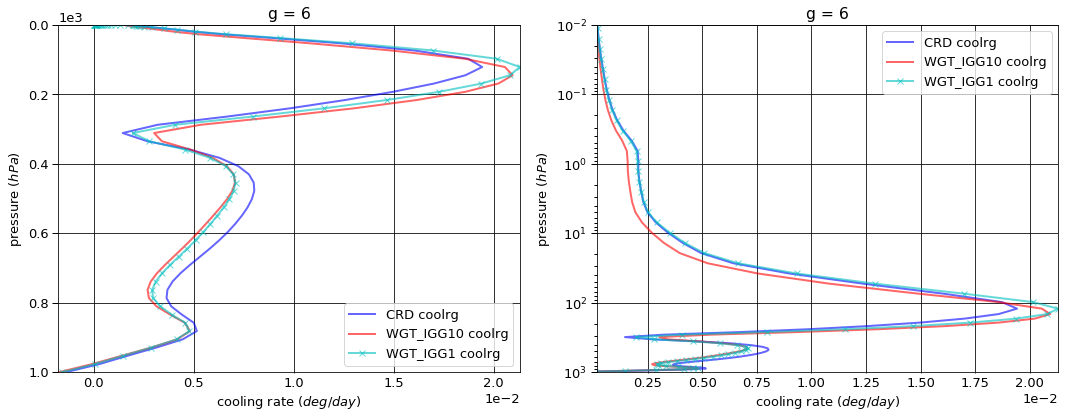

# Figure: cooling rate g-group 7

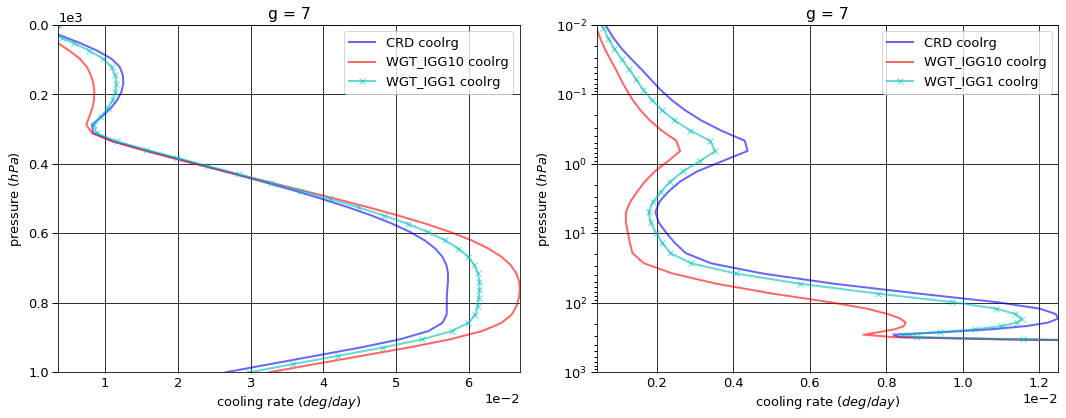

# Figure: cooling rate g-group 8

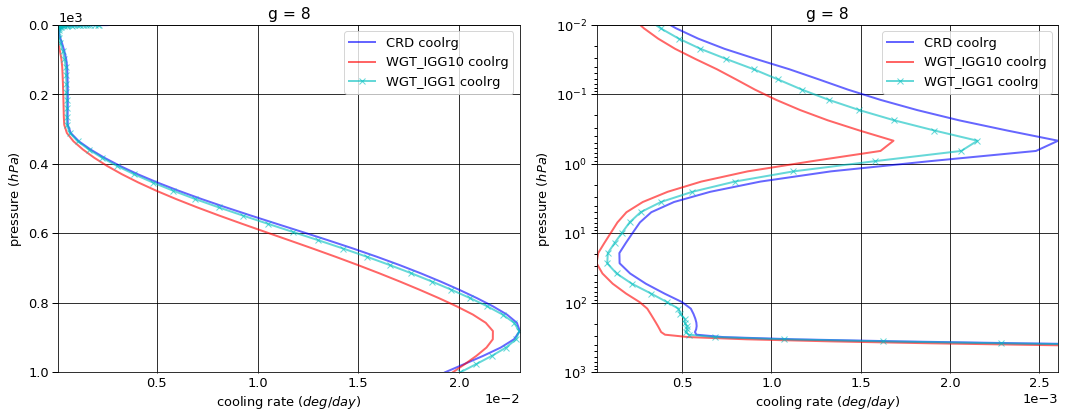

# Figure: cooling rate g-group 9

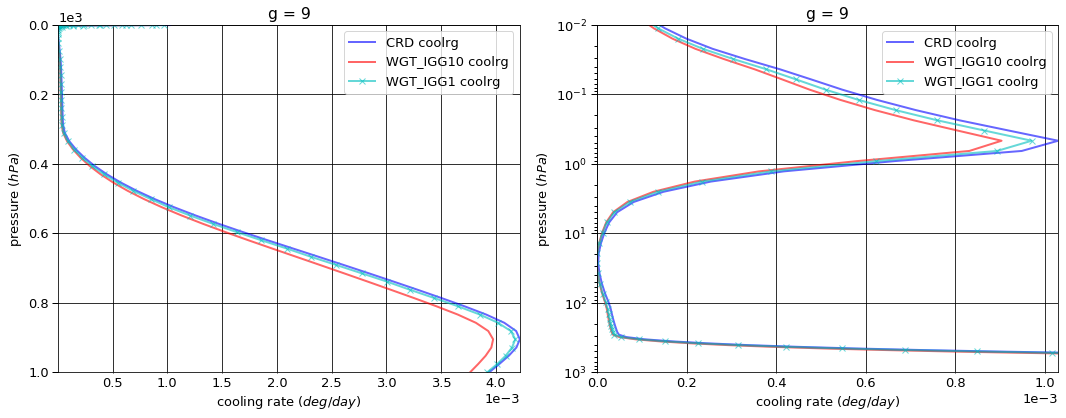

# Figure: cooling rate g-group total

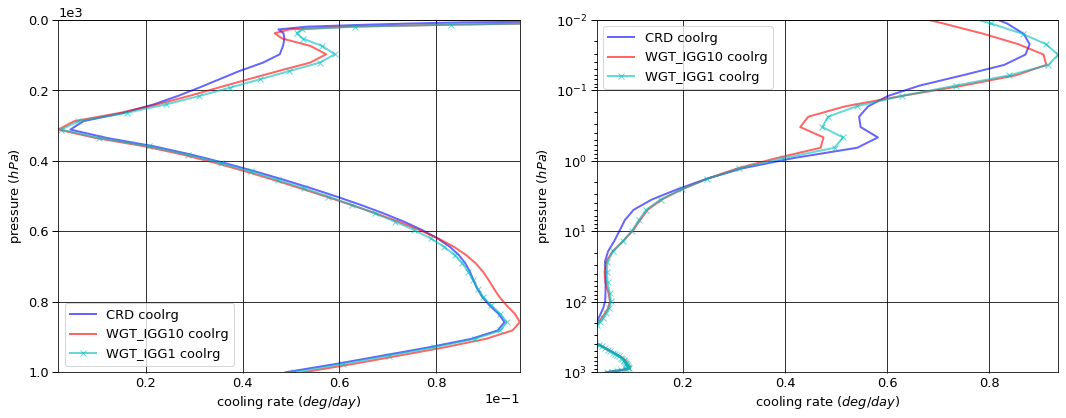

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012418  0.000000 -0.012418
  1013.0   76    -0.014389  0.014467  0.000078
2 0.0      1     -0.025993  0.000000 -0.025993
  1013.0   76    -0.031723  0.031962  0.000238
3 0.0      1     -0.122925  0.000000 -0.122925
  1013.0   76    -0.182604  0.173562 -0.009042
4 0.0      1     -0.163991  0.000000 -0.163991
  1013.0   76    -0.311644  0.312384  0.000739
5 0.0      1     -0.662841  0.000000 -0.662841
  1013.0   76    -1.088675  0.985748 -0.102927
6 0.0      1     -0.843314  0.000000 -0.843314
  1013.0   76    -1.484570  1.498960  0.014390
7 0.0      1     -4.963365  0.000000 -4.963365
  1013.0   76    -6.246597  5.213610 -1.032987
8 0.0      1     -5.212257  0.000000 -5.212257
  1013.0   76    -5.384018  1.337230 -4.046788
9 0.0      1     -8.829694  0.000000 -8.829694
  1013.0   76    -8.846916  0.207557 -8.639359


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012339  0.000000 -0.012339
  1013.0   76    -0.014319  0.014387  0.000067
2 0.0      1     -0.026102  0.000000 -0.026102
  1013.0   76    -0.031582  0.031733  0.000152
3 0.0      1     -0.115914  0.000000 -0.115914
  1013.0   76    -0.181957  0.182890  0.000933
4 0.0      1     -0.164251  0.000000 -0.164251
  1013.0   76    -0.310280  0.311749  0.001469
5 0.0      1     -0.576454  0.000000 -0.576454
  1013.0   76    -1.085131  1.093927  0.008796
6 0.0      1     -0.830791  0.000000 -0.830791
  1013.0   76    -1.478767  1.494498  0.015730
7 0.0      1     -5.037082  0.000000 -5.037082
  1013.0   76    -6.227551  5.450051 -0.777500
8 0.0      1     -5.246439  0.000000 -5.246439
  1013.0   76    -5.386883  1.195228 -4.191656
9 0.0      1     -8.858764  0.000000 -8.858764
  1013.0   76    -8.874667  0.192318 -8.682349


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.012295  0.000000 -0.012295
  1013.0   76    -0.014319  0.014387  0.000067
2 0.0      1     -0.026035  0.000000 -0.026035
  1013.0   76    -0.031582  0.031736  0.000155
3 0.0      1     -0.116103  0.000000 -0.116103
  1013.0   76    -0.181957  0.182942  0.000985
4 0.0      1     -0.164840  0.000000 -0.164840
  1013.0   76    -0.310280  0.311771  0.001491
5 0.0      1     -0.578509  0.000000 -0.578509
  1013.0   76    -1.085131  1.094699  0.009568
6 0.0      1     -0.836108  0.000000 -0.836108
  1013.0   76    -1.478767  1.494052  0.015284
7 0.0      1     -4.973406  0.000000 -4.973406
  1013.0   76    -6.227551  5.369234 -0.858317
8 0.0      1     -5.220788  0.000000 -5.220788
  1013.0   76    -5.386883  1.314639 -4.072244
9 0.0      1     -8.857586  0.000000 -8.857586
  1013.0   76    -8.874667  0.203488 -8.671179


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000079  0.000000  0.000079
  1013.0   76     0.000070 -0.000080 -0.000011
2 0.0      1     -0.000109  0.000000 -0.000109
  1013.0   76     0.000142 -0.000228 -0.000087
3 0.0      1      0.007010  0.000000  0.007010
  1013.0   76     0.000647  0.009328  0.009975
4 0.0      1     -0.000260  0.000000 -0.000260
  1013.0   76     0.001364 -0.000635  0.000730
5 0.0      1      0.086387  0.000000  0.086387
  1013.0   76     0.003544  0.108179  0.111723
6 0.0      1      0.012523  0.000000  0.012523
  1013.0   76     0.005803 -0.004463  0.001340
7 0.0      1     -0.073718  0.000000 -0.073718
  1013.0   76     0.019046  0.236441  0.255487
8 0.0      1     -0.034183  0.000000 -0.034183
  1013.0   76    -0.002865 -0.142002 -0.144867
9 0.0      1     -0.029069  0.000000 -0.029069
  1013.0   76    -0.027751 -0.015240 -0.042990


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000123  0.000000  0.000123
  1013.0   76     0.000070 -0.000080 -0.000010
2 0.0      1     -0.000043  0.000000 -0.000043
  1013.0   76     0.000142 -0.000226 -0.000084
3 0.0      1      0.006822  0.000000  0.006822
  1013.0   76     0.000647  0.009379  0.010026
4 0.0      1     -0.000849  0.000000 -0.000849
  1013.0   76     0.001364 -0.000612  0.000752
5 0.0      1      0.084332  0.000000  0.084332
  1013.0   76     0.003544  0.108951  0.112495
6 0.0      1      0.007206  0.000000  0.007206
  1013.0   76     0.005803 -0.004909  0.000894
7 0.0      1     -0.010041  0.000000 -0.010041
  1013.0   76     0.019046  0.155624  0.174670
8 0.0      1     -0.008531  0.000000 -0.008531
  1013.0   76    -0.002865 -0.022590 -0.025456
9 0.0      1     -0.027892  0.000000 -0.027892
  1013.0   76    -0.027751 -0.004070 -0.031820

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      2.035315e-01
  1001.112500 75    -1.213256e-05
2 0.000312    1      3.508659e-03
  1001.112500 75    -3.080874e-05
3 0.000312    1      1.009702e-02
  1001.112500 75     5.364404e-05
4 0.000312    1      2.354543e-04
  1001.112500 75    -1.889591e-04
5 0.000312    1      1.502831e-03
  1001.112500 75     6.428129e-04
6 0.000312    1      3.371124e-05
  1001.112500 75    -1.408406e-03
7 0.000312    1      7.877151e-05
  1001.112500 75     2.659087e-02
8 0.000312    1      1.575269e-05
  1001.112500 75     1.930559e-02
9 0.000312    1      4.573185e-07
  1001.112500 75     3.937681e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      8.919878e-02
  1001.112500 75    -1.043335e-05
2 0.000312    1      5.092676e-03
  1001.112500 75    -2.365209e-05
3 0.000312    1      1.162370e-02
  1001.112500 75    -1.482544e-04
4 0.000312    1      2.581214e-04
  1001.112500 75    -2.276775e-04
5 0.000312    1      2.016906e-03
  1001.112500 75    -1.272884e-03
6 0.000312    1      2.698258e-05
  1001.112500 75    -1.762062e-03
7 0.000312    1      4.457443e-05
  1001.112500 75     3.259103e-02
8 0.000312    1     -8.834998e-07
  1001.112500 75     1.969184e-02
9 0.000312    1     -2.269805e-06
  1001.112500 75     3.763073e-03


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1      0.148578
  1001.112500 75    -0.000010
2 0.000312    1      0.004936
  1001.112500 75    -0.000024
3 0.000312    1      0.011547
  1001.112500 75    -0.000157
4 0.000312    1      0.000279
  1001.112500 75    -0.000232
5 0.000312    1      0.002288
  1001.112500 75    -0.001233
6 0.000312    1      0.000035
  1001.112500 75    -0.001589
7 0.000312    1      0.000080
  1001.112500 75     0.029857
8 0.000312    1      0.000008
  1001.112500 75     0.020065
9 0.000312    1     -0.000002
  1001.112500 75     0.003920


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.114333
  1001.112500 75     0.000002
2 0.000312    1      0.001584
  1001.112500 75     0.000007
3 0.000312    1      0.001527
  1001.112500 75    -0.000202
4 0.000312    1      0.000023
  1001.112500 75    -0.000039
5 0.000312    1      0.000514
  1001.112500 75    -0.001916
6 0.000312    1     -0.000007
  1001.112500 75    -0.000354
7 0.000312    1     -0.000034
  1001.112500 75     0.006000
8 0.000312    1     -0.000017
  1001.112500 75     0.000386
9 0.000312    1     -0.000003
  1001.112500 75    -0.000175


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.054953
  1001.112500 75     0.000002
2 0.000312    1      0.001428
  1001.112500 75     0.000007
3 0.000312    1      0.001450
  1001.112500 75    -0.000210
4 0.000312    1      0.000043
  1001.112500 75    -0.000043
5 0.000312    1      0.000785
  1001.112500 75    -0.001875
6 0.000312    1      0.000002
  1001.112500 75    -0.000181
7 0.000312    1      0.000001
  1001.112500 75     0.003266
8 0.000312    1     -0.000007
  1001.112500 75     0.000760
9 0.000312    1     -0.000003
  1001.112500 75    -0.000018

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.836798,0.00000,-20.836798
1013.0,76,-23.591138,9.77548,-13.815657



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.868137,0.00000,-20.868137
1013.0,76,-23.591138,9.96678,-13.624358



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.785670,0.000000,-20.78567
1013.0,76,-23.591138,10.016948,-13.57419



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.133893e-02,0.000000,-0.031339
1013.0,76,2.550000e-07,0.191299,0.191299



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,5.112766e-02,0.000000,0.051128
1013.0,76,2.550000e-07,0.241468,0.241468


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.219004
1001.112500,75,0.048890



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.108259
1001.112500,75,0.052601



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.167750
1001.112500,75,0.050596



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.110746
1001.112500,75,0.003711



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.051255
1001.112500,75,0.001705


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000625,0.000607
2,0.001375,0.001339
3,0.007875,0.007713
4,0.013500,0.013152
5,0.046875,0.045997
6,0.064125,0.062683
7,0.268500,0.263978
8,0.227375,0.228344
9,0.369750,0.376186


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.333865e-19
2,2.151599e-20
3,1.983568e-21
4,1.777292e-21
5,1.650053e-22
6,7.272858e-22
7,6.811052e-23
8,6.378569e-24
9,1.012133e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.333865e-19,NaN,0.000625,0.000607,0.000625,0.000607,1.0
2,2.151599e-20,0.092190,0.001375,0.001339,0.002000,0.001946,1.0
3,1.983568e-21,0.092190,0.007875,0.007713,0.009875,0.009659,1.0
4,1.777292e-21,0.896007,0.013500,0.013152,0.023375,0.022811,10.0
5,1.650053e-22,0.092841,0.046875,0.045997,0.070250,0.068808,10.0
6,7.272858e-22,4.407650,0.064125,0.062683,0.134375,0.131492,500.0
7,6.811052e-23,0.093650,0.268500,0.263978,0.402875,0.395470,500.0
8,6.378569e-24,0.093650,0.227375,0.228344,0.630250,0.623814,500.0
9,1.012133e-25,0.015868,0.369750,0.376186,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
